### Install dependencies

In [1]:
from IPython.display import clear_output
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

!pip install portalocker
!pip install spacy sacrebleu torchdata -U
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

clear_output()

### Imports

In [2]:
import numpy as np

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
from torch.nn.utils.rnn import pad_sequence
from typing import Iterable, List
from tqdm.auto import tqdm

import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Transformer
import math
import matplotlib.pyplot as plt

from sacrebleu.metrics import BLEU, CHRF, TER

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/NLP/Deep/lab02/')

from scripts.utils import *
from scripts.preprocessing.positional_encoding import PositionalEncoding
from scripts.preprocessing.token_embedding import TokenEmbedding
from scripts.model.transformer import Seq2SeqTransformer
from scripts.model.helper import train

# Decoding
from scripts.decoding.greedy import greedy_translate
from scripts.decoding.top_k import translate_k
from scripts.decoding.top_p import translate_top_p

## Encoder-decoder model

Today you will implement a pretty decent machine translation model using the transformer and implement several decoding strategy.

###  Go through the pyTorch tutorial

To start with, just follow the pyTorch [language translation with nn.Transformer and torchtext tutorial](https://pytorch.org/tutorials/beginner/translation_transformer.html).

To make the code turn on Google Colab, you need to update the preinstalled version of spaCy and download the small German and English spaCy models. As pyTorch doesn't seem to maintain its tutorial with their most recent changes, you also need to install torchdata.
```
!pip install spacy sacrebleu torchdata -U
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm
```

As the training takes time (~20min), you can start looking at the following steps while it finishes.

At training, you will encounter `TypeError: ZipperIterDataPipe instance doesn't have valid length` (pyTorch doesn't update their tutorials). A workaround can be found [here](https://github.com/pytorch/tutorials/issues/1868).

### Download data

In [4]:
# We need to modify the URLs for the dataset since the links to the original dataset are broken
# Refer to https://github.com/pytorch/text/issues/1756#issuecomment-1163664163 for more info
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"

DEVICE = get_device()

SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}

### Build vocabulary

In [5]:
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

build_vocabulary(vocab_transform, token_transform, SRC_LANGUAGE, TGT_LANGUAGE, UNK_IDX, special_symbols)

### Model

The model is defined in the `scripts/model/transformer.py`. All the preprocessing layers are defined at `scripts/preprocessing/*.py`.

During training, we need a subsequent word mask that will prevent the model from looking into the future words when making predictions. We will also need masks to hide source and target padding tokens. Below, let's define a function that will take care of both. The masks are implemented at `scripts/utils.py`.

### Training

Let's now define the parameters of our model and instantiate the same. Below, we also define our loss function which is the cross-entropy loss and the optimizer used for training.

In [6]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

As seen in the Data Sourcing and Processing section, our data iterator yields a pair of raw strings. We need to convert these string pairs into the batched tensors that can be processed by our Seq2Seq network defined previously. Below we define our collate function that converts a batch of raw strings into batch tensors that can be fed directly into our model.

In [7]:
# ``src`` and ``tgt`` language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform,
                                               bos_idx=BOS_IDX,
                                               eos_idx=EOS_IDX
                                               ) # Add BOS/EOS and create tensor

Let's define training and evaluation loop that will be called for each epoch. The training and evaluation are implement at `./scripts/model/helper.py`

Now we have all the ingredients to train our model. Let's do it!

  0%|          | 0/18 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/datapipes/iter/combining.py:297: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


Epoch: 1, Train loss: 5.344, Val loss: 4.114
Epoch: 2, Train loss: 3.760, Val loss: 3.320
Epoch: 3, Train loss: 3.161, Val loss: 2.895
Epoch: 4, Train loss: 2.768, Val loss: 2.639
Epoch: 5, Train loss: 2.480, Val loss: 2.443
Epoch: 6, Train loss: 2.251, Val loss: 2.318
Epoch: 7, Train loss: 2.061, Val loss: 2.201
Epoch: 8, Train loss: 1.897, Val loss: 2.112
Epoch: 9, Train loss: 1.754, Val loss: 2.061
Epoch: 10, Train loss: 1.631, Val loss: 2.002
Epoch: 11, Train loss: 1.524, Val loss: 1.969
Epoch: 12, Train loss: 1.419, Val loss: 1.942
Epoch: 13, Train loss: 1.334, Val loss: 1.968
Epoch: 14, Train loss: 1.252, Val loss: 1.944
Epoch: 15, Train loss: 1.173, Val loss: 1.933
Epoch: 16, Train loss: 1.103, Val loss: 1.922
Epoch: 17, Train loss: 1.039, Val loss: 1.899
Epoch: 18, Train loss: 0.979, Val loss: 1.906


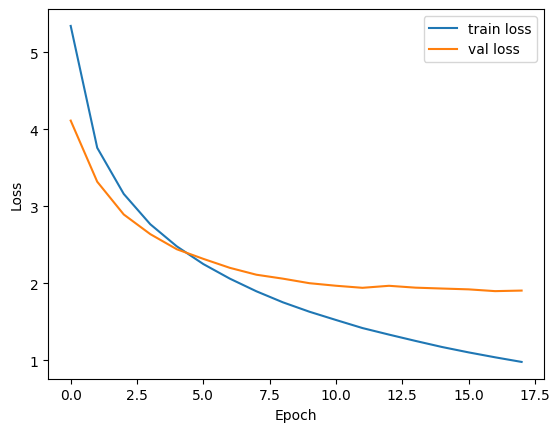

In [8]:
from timeit import default_timer as timer
NUM_EPOCHS = 18

# Load pre trained model if not training one
# transformer.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/transformer.pt'))

train_losses, val_losses = train(transformer,
                                 optimizer,
                                 SRC_LANGUAGE,
                                 TGT_LANGUAGE,
                                 loss_fn,
                                 BATCH_SIZE,
                                 PAD_IDX,
                                 text_transform,
                                 NUM_EPOCHS,
                                 DEVICE)
# Plot the loss curves
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save model
# torch.save(transformer.state_dict(), '/content/drive/MyDrive/Colab Notebooks/transformer.pt')

In [9]:
print(greedy_translate(transformer,
                       "Eine Gruppe von Menschen steht vor einem Iglu .",
                       text_transform,
                       vocab_transform,
                       SRC_LANGUAGE,
                       TGT_LANGUAGE,
                       start_symbol=BOS_IDX,
                       eos_idx=EOS_IDX,
                       device=DEVICE))

 A group of people standing in front of an igloo . 


### **(4 points)** Theoretical questions

Answer the following questions.

* In the positional encoding, why are we using a combination of sinus and cosinus?
* In the `Seq2SeqTransformer` class,
  * What is the parameter nhead for?
  * What is the point of the `generator`?
* Describe the goal of the `create_mask` function. Why does it handle differently the source and target masks?

`In the positional encoding, why are we using a combination of sinus and cosinus ?`

The use of sine and cosine functions in positional encoding is a strategy to embed the positional information of tokens in the sequence. It's important to note that the purpose of this positional encoding is to allow the model to learn to use this information, rather than explicitly tell the model the absolute position of each token.

Here's a more detailed explanation of why we use a combination of sine and cosine functions:

Uniqueness: Each position gets a unique positional encoding. With the combination of sine and cosine functions of different frequencies, we can represent the positional information uniquely. Moreover, these positional encodings can be learned and are able to generalize to sequence lengths longer than the ones encountered during training.

Relative positions: The Transformer model needs to understand not just the absolute position of the tokens in a sequence, but also the relative positions between tokens. The sine and cosine functions have a repeating pattern, which provides a way to capture the concept of relative position. More technically, for any fixed offset k, PE(pos+k) can be represented as a linear function of PE(pos).

Continuous representation: While the absolute position of each token could be included as a simple integer (1, 2, 3, ...), this would be a large, sparse vector and might not be as effectively learned by the model. Sinusoidal functions provide a smooth, continuous representation that may be easier for the model to generalize.

They don't require a lot of memory: Unlike some other methods for encoding position, the sinusoidal method doesn't require any learned parameters. This makes it efficient and scalable.

The choice of sine for even indices and cosine for odd indices is somewhat arbitrary; it's just a way to get two different signals that may be easier for the model to distinguish.







`In the SEQ2SEQTRANSFORMER class`

* What is the parameter nhead for?

In the context of the Seq2SeqTransformer class and specifically the Transformer model in PyTorch, the nhead parameter stands for the number of heads in the multi-head self-attention mechanisms.

The Transformer uses a mechanism called self-attention, where it calculates an attention score for each input in the context of the entire sequence. The concept of multi-head attention means that this process is not done once but multiple times in parallel, with each "head" potentially learning to pay attention to different aspects of the input.

Each head gets a portion of the input representation, performs self-attention independently, and then the results are concatenated and linearly transformed to result in the final output.

In essence, nhead controls the number of distinct representation spaces the model can learn from and can help the model capture various aspects of the input data at different levels of abstraction. It's a hyperparameter that you can tune to optimize performance.

In practice, you often see nhead set to 8 or 16 in Transformer models. This means that the self-attention mechanism is applied 8 or 16 times in parallel to each input. Each of these heads may learn to pay attention to different features in the data, thus helping to improve the model's performance.

* What is the point of the generator?

The generator is a linear layer that maps the model's output back to the size of the vocabulary. It is applied to the output of the decoder's self-attention layer and the encoder-decoder attention layer.

The purpose of this is to transform the high-dimensional encoder-decoder output into a space that matches the number of classes (i.e., the size of the target vocabulary) that the model needs to predict. This is typically done by a linear (also known as fully connected) layer.

* Describe the goal of the `create_mask` function. Why does it handle differently the source and target masks?

The create_mask function creates four different masks, each serving a different purpose in the transformer architecture. These masks are utilized in the transformer to prevent attention to certain tokens : 

* `src_mask`: This mask is a square matrix of zeros. It's designed to be applied on source sequences in the encoder. In this particular implementation, all source tokens can attend to all other tokens (there's no masking in the encoder apart from padding), hence all values in the mask are zero.

* `tgt_mask`: This is a "look-ahead" mask or "future" mask for the target sequences. It's used in the decoder to prevent a token from attending to future tokens in the same sequence, which enforces the autoregressive property. This mask is generated using the generate_square_subsequent_mask function which creates a square matrix with ones below the diagonal and zeros on and above the diagonal. The ones are then replaced with zeros and the zeros with negative infinity. The negative infinity values ensure that, after applying a softmax, these positions yield a near zero attention score, effectively masking them.

* `src_padding_mask` and `tgt_padding_mask`: These masks are used to prevent the model from paying attention to padding tokens in the source and target sequences, respectively. They are generated by comparing each token in the source and target sequences to the padding index (PAD_IDX); a True (or 1) is output where there's a pad token and a False (or 0) elsewhere.

The reason for different handling between source and target masks is due to the distinct roles of the encoder and decoder:

The encoder processes the entire input sequence at once and thus needs to mask only the padding tokens (using src_padding_mask), not future tokens, so there's no need for a look-ahead mask.
The decoder, on the other hand, is designed to generate each token one at a time, conditioned on previous tokens. Therefore, it needs the look-ahead mask (tgt_mask) to prevent each token from seeing future tokens, and also the padding mask (tgt_padding_mask) to ignore pad tokens. This is why the target mask is more complex and created differently from the source mask.

### **(6 points)** Decoding functions  
The tutorial uses a greedy approach at decoding. Implement the following variations.
* (3 points) A top-k sampling with temperature.
* (1 point) A top-p sampling with temperature.
* (2 point) Play with the k, p and temperature parameters, and qualitatively compare a few (at least 3) translation samples for each approach (even the greedy one).


`Top-k sampling with temperature`


In [10]:
print(translate_k(transformer,
                  "Eine Gruppe von Menschen steht vor einem Iglu .",
                  text_transform,
                  vocab_transform,
                  SRC_LANGUAGE,
                  TGT_LANGUAGE,
                  start_symbol=BOS_IDX,
                  eos_idx=EOS_IDX,
                  k=4,
                  temperature=0.1,
                  device=DEVICE))

 A group of people standing in front of an igloo . 


Top-k sampling introduces an element of randomness in the generation process which leads to different outputs even for the same input.

`Top-p sampling with temperature`

In [11]:
print(translate_top_p(transformer,
                      "Eine Gruppe von Menschen steht vor einem Iglu .",
                      text_transform,
                      vocab_transform,
                      SRC_LANGUAGE,
                      TGT_LANGUAGE,
                      start_symbol=BOS_IDX,
                      eos_idx=EOS_IDX,
                      p=0.9,
                      temperature=0.2,
                      device=DEVICE))

 A group of people stand in front of an igloo . 


#### Parameter search (k, p, temperature)

First, we load the testing set.

In [12]:
test_iter = Multi30k(split='test', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
samples = []
for (src, tgt) in test_iter: 
  if len(samples) == 3:
    break
  samples.append([src, tgt])

samples = np.array(samples)

Let us see the results of the decoding function with the parameter k in top-k sampling

In [13]:
k_values: list[int] = [2, 5, 10]

generated_translation_samples = []
for k in k_values:
  translation_list = []
  for sample in samples[:, 0]:
    translation = translate_k(transformer, str(sample), text_transform, vocab_transform, SRC_LANGUAGE, TGT_LANGUAGE, start_symbol=BOS_IDX, eos_idx=EOS_IDX, k=k, temperature=0.1, device=DEVICE)
    translation_list.append(translation)
  generated_translation_samples.append(translation_list)

for i in range(len(generated_translation_samples)):
  print('\n')
  print(f'k: {k_values[i]}')
  for j in range(len(generated_translation_samples[i])):
    print(f'Generated translation: {generated_translation_samples[i][j]}')
    print(f'Ground truth: {samples[j][1]}')



k: 2
Generated translation:  A man with an orange hat is taking something trick . 
Ground truth: A man in an orange hat starring at something.
Generated translation:  A cute puppy runs over the grass in front of a white fence . 
Ground truth: A Boston Terrier is running on lush green grass in front of a white fence.
Generated translation:  A girl in a karate uniform is welding a stick with a stick . 
Ground truth: A girl in karate uniform breaking a stick with a front kick.


k: 5
Generated translation:  A man with an orange hat is using something move . 
Ground truth: A man in an orange hat starring at something.
Generated translation:  A cute puppy runs over the grass in front of a white fence . 
Ground truth: A Boston Terrier is running on lush green grass in front of a white fence.
Generated translation:  A girl in a karate uniform is welding a stick with a stick . 
Ground truth: A girl in karate uniform breaking a stick with a front kick.


k: 10
Generated translation:  A man wi

In our top-k sampling, we can see that there is alway a part of the sentence that is correct and consitent. However, we can observe that there is a form of confusion with verbs. For instance, an equivalent of 'to stare at' coud not be found by the transformer. Indeed, the lack of combination of a verb and a preposition create unconsistency in the translation. Besides, the name <i>Boston Terrier</i> is not properly translated. It is always translated using adjectives and common nouns.

In [14]:
p_values: list[int] = [0.25, 0.5, 0.85]

generated_translation_samples = []
for p in p_values:
  translation_list = []
  for sample in samples[:, 0]:
    translation = translate_top_p(transformer, str(sample), text_transform, vocab_transform, SRC_LANGUAGE, TGT_LANGUAGE, start_symbol=BOS_IDX, eos_idx=EOS_IDX, p=p, temperature=0.2, device=DEVICE)
    translation_list.append(translation)
  generated_translation_samples.append(translation_list)

for i in range(len(generated_translation_samples)):
  print(f'p: {p_values[i]}')
  for j in range(len(generated_translation_samples[i])):
    print(f'Generated translation: {generated_translation_samples[i][j]}')
    print(f'Ground truth: {samples[j][1]}')
  print('\n')

p: 0.25
Generated translation:  A man with an orange hat is using something control . 
Ground truth: A man in an orange hat starring at something.
Generated translation:  A cute puppy runs over the grass in front of a white fence . 
Ground truth: A Boston Terrier is running on lush green grass in front of a white fence.
Generated translation:  A girl in a karate uniform is welding a stick with a stick . 
Ground truth: A girl in karate uniform breaking a stick with a front kick.


p: 0.5
Generated translation:  A man with an orange hat is using something control . 
Ground truth: A man in an orange hat starring at something.
Generated translation:  A cute puppy runs over the grass in front of a white fence . 
Ground truth: A Boston Terrier is running on lush green grass in front of a white fence.
Generated translation:  A girl in a karate uniform is welding a stick with a stick . 
Ground truth: A girl in karate uniform breaking a stick with a front kick.


p: 0.85
Generated translation: 

Using top-p sampling, we obtain similar results, we the same mistakes as with top-k sampling. As we use the same temperature in both methods, we could wonder whether the temperature the most impactful factor.

In [15]:
temperatures: list[int] = [0.1, 0.3, 0.6, 0.9]

generated_translation_samples = []
for temperature in temperatures:
  translation_list = []
  for sample in samples[:, 0]:
    translation = translate_top_p(transformer, str(sample), text_transform, vocab_transform, SRC_LANGUAGE, TGT_LANGUAGE, start_symbol=BOS_IDX, eos_idx=EOS_IDX, p=0.9, temperature=temperature, device=DEVICE)
    translation_list.append(translation)
  generated_translation_samples.append(translation_list)

for i in range(len(generated_translation_samples)):
  print(f'temperature: {temperatures[i]}')
  for j in range(len(generated_translation_samples[i])):
    print(f'Generated translation: {generated_translation_samples[i][j]}')
    print(f'Ground truth: {samples[j][1]}')
  print('\n')

temperature: 0.1
Generated translation:  A man with an orange hat is using something move . 
Ground truth: A man in an orange hat starring at something.
Generated translation:  A cute puppy runs over the grass in front of a white fence . 
Ground truth: A Boston Terrier is running on lush green grass in front of a white fence.
Generated translation:  A girl in a karate uniform is welding a stick with a stick . 
Ground truth: A girl in karate uniform breaking a stick with a front kick.


temperature: 0.3
Generated translation:  A man with an orange hat who is using something black belt . 
Ground truth: A man in an orange hat starring at something.
Generated translation:  A cute puppy runs over the grass in front of a white fence . 
Ground truth: A Boston Terrier is running on lush green grass in front of a white fence.
Generated translation:  A girl in a karate uniform is welding a stick with a stick . 
Ground truth: A girl in karate uniform breaking a stick with a front kick.


temperat

We can see here that we do not necessarily obtain better results than previously, as we already used a minimal value for the temperature. However, the temperature does change the model output considerably. The higher the temperature, the less is the generated translation semantically correct.

### **(2 points)** Compute the BLEU score of the model

Use the [sacreBLEU](https://github.com/mjpost/sacreBLEU) implementation to evaluate your model and quantitatively compare the 3 implemented decoding approaches **on the full test set**. Explain what all the output values mean (when using the `corpus_score` function).

In the [python section](https://github.com/mjpost/sacrebleu#using-sacrebleu-from-python), you'll notice the library accepts more than just one possible translation as reference, but the given dataset only has one translation per sample.

Using the `translate` function provided in the tutorial is pretty slow, as it translate text by text. It's recommended you modify the function to accept a list of texts as input, and batch them for translations (also **bonus point**).

**\[Bonus\]** Use part of the test set to perform an hyperparameters search on the value of temperature, k, and p. Note that, normally, this should be done on a validation set, not the test set.

We first need to create a reference list for the entire corpus. We can do this by iterating over the test dataset and appending the target sentence to a list.

In [16]:
refs = []
for (src, tgt) in test_iter:
        refs.append([tgt])

#### BLEU Score - Greedy decoding

In [17]:
# Generate the predictions
sys = []
for (src, tgt) in test_iter:
        sys.append(
                greedy_translate(transformer,
                                        str(src),
                                        text_transform,
                                        vocab_transform,
                                        SRC_LANGUAGE,
                                        TGT_LANGUAGE,
                                        start_symbol=BOS_IDX,
                                        eos_idx=EOS_IDX,
                                        device=DEVICE)
        )

# compute BLEU score
bleu = BLEU()
bleu_score = bleu.corpus_score(sys, refs)

print(bleu_score)

BLEU = 51.57 90.9/70.0/44.4/25.0 (BP = 1.000 ratio = 1.000 hyp_len = 11 ref_len = 11)


#### BLEU Score - Top-k sampling with temperature

In [18]:
# Generate predictions with top-k sampling
sys_topk = []
for (src,tgt) in test_iter:
    translation = translate_k(transformer,
                                str(src),
                                text_transform,
                                vocab_transform,
                                SRC_LANGUAGE,
                                TGT_LANGUAGE,
                                start_symbol=BOS_IDX,
                                eos_idx=EOS_IDX,
                                k=5,
                                temperature=0.1,
                                device=DEVICE)
    sys_topk.append(translation)  # translation is a string

# compute BLEU score
bleu = BLEU()
bleu_score = bleu.corpus_score(sys_topk, refs)

print(bleu_score)

BLEU = 54.60 100.0/80.0/44.4/25.0 (BP = 1.000 ratio = 1.000 hyp_len = 11 ref_len = 11)


#### BLEU Score - Top-p sampling with temperature

In [19]:
# Generate predictions with top-p sampling
sys_top_p = []
for (src,tgt) in test_iter:
    translation = translate_top_p(transformer,
                                str(src),
                                text_transform,
                                vocab_transform,
                                SRC_LANGUAGE,
                                TGT_LANGUAGE,
                                start_symbol=BOS_IDX,
                                eos_idx=EOS_IDX,
                                p=0.9,
                                temperature=0.2,
                                device=DEVICE)
    sys_top_p.append(translation)

# compute BLEU score
bleu = BLEU()
bleu_score_top_p = bleu.corpus_score(sys_top_p, refs)

print(bleu_score_top_p)

BLEU = 42.80 92.3/50.0/36.4/20.0 (BP = 1.000 ratio = 1.000 hyp_len = 13 ref_len = 13)


The output obtained is a result of the BLEU (Bilingual Evaluation Understudy) metric, which is a method for evaluating the quality of text that has been machine-translated from one language to another. BLEU scores are based on the comparison between the machine-generated translation and one or more human-created reference translations.

Here's an explanation of each output value:

- `BLEU = 51.57`: This is the final BLEU score. The BLEU score can range from 0 to 100. A higher score indicates a greater match with the reference translation. A score of 100 indicates a perfect match with the reference.

- `90.9/70.0/44.4/25.0`: These are the scores of the n-gram precisions for n=1, 2, 3, and 4 respectively. These scores show the precision of individual n-grams in the translation. For example, 90.9 is the precision of unigrams (individual words), 70.0 is the precision of bigrams (pairs of words), and so on.

- `(BP = 1.000)`: BP stands for "Brevity Penalty". This is a penalty applied if the produced translation is shorter than the reference. If the translation is the same length as the reference or longer, the brevity penalty is 1. If the translation is shorter, the brevity penalty is less than 1.

- `ratio = 1.000`: This is the ratio of the length of the translation to the length of the reference. A ratio of 1 means the translation and the reference are of the same length.

- `hyp_len = 11`: This is the length of the machine-generated translation (hypothesis).

- `ref_len = 11`: This is the length of the reference translation.

Note that all these values are calculated for a single translation evaluation. BLEU scores are usually calculated over a large number of translations to get a general evaluation of a machine's translation quality.